# Scikit-learn for Machine Learning

## Preparation

- Download and Install [Anaconda](https://www.continuum.io/downloads) (Python 3 version)
- Run command in a new shell: `jupyter lab`
- If you run jupyter lab in a linux server through ssh, open a new terminal
    - `ssh -L 8000:localhost:(jupyter port, default is 8888) (user)@(server address)`
    - after log in, `jupyter notebook list`, check and copy the token of your jupyter
    - open browser http://localhost:8000/, enter the token
- Create a new notebook: Left-upper area -> "+" (New launcher) -> Notebook -> Python 3

## What is Scikit-learn?

- Scikit-learn: Machine Learning in Python
    - Simple and efficient tools for data mining and data analysis
    - Accessible to everybody, and reusable in various contexts
    - Built on NumPy, SciPy, and matplotlib
    - Open source, commercially usable - BSD license
- Features:
    - Classification
    - Regression
    - Clustering
    - Dimensionality reduction
    - Model selection
    - Preprocessing

Reference: [Scikit-learn official site](http://scikit-learn.org/stable/)

## Contents

1. Machine Learning Theory
    - Loss Function
    - Training-Validation Sets
    - Cross-Validation
2. An Example for CV Training: Linear Regression
3. Over-fitting
    - Penalty Function
    - Ridge and Lasso
    - Select Penalty Coeffient
4. Tree-based Models
    - Decision Tree
    - Random Forest
    - Gradient Boosting Trees

## Scikit-learn (1) Data Preprocessing
Reference: [scikit-learn preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)

In [1]:
# Load modules and set options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline

np.set_printoptions(precision = 3)
pd.set_option('precision', 3)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

In [2]:
# Load price-missing data and true label data
da = pd.read_csv("Diamonds.csv", index_col = "n")
da_true = pd.read_csv("Diamonds_predict_true.csv", index_col = "n")
da.shape, da_true.shape

((53940, 10), (14232, 10))

In [3]:
# Separate X and Y
Y, X = da['price'], da.drop('price', axis = 1)
Y.shape, X.shape

((53940,), (53940, 9))

In [4]:
# Denote labeled and unlabeled row index
ir_unlab, ir_lab = da.index[Y.isna()], da.index[~Y.isna()]
ir_unlab.shape, ir_lab.shape

((14232,), (39708,))

## How to get help

- From Function Help: ? + function
    - `?metrics.log_loss`
- From Autofill with *Tab*:
    - `metrics.` + *Tab*
- From Google: Your Question (what you want to do) + scikit-learn
    - logistic regression scikit-learn
    - speed up random forest scikit-learn
- From Official Website: http://scikit-learn.org/

## Scikit-learn (1.1): Separate categorical and numerical variables

- Categorical and numerical has different features
- For categorical variables
    - Create dummy variables
- For numerical variables
    - Scale with mean 0 and std 1
    - Interaction / polynomial (if necessary)
- For both
    - Remove non-frequent variables
    - Remove collinearity variables

In [5]:
# Numeric variable
X_num = X.select_dtypes(np.number)
X_num.head()

,carat,depth,table,x,y,z
n,,,,,,
1,0.23,61.5,55.0,3.95,3.98,2.43
2,0.21,59.8,61.0,3.89,3.84,2.31
3,0.23,56.9,65.0,4.05,4.07,2.31
4,0.29,62.4,58.0,4.20,4.23,2.63
5,0.31,63.3,58.0,4.34,4.35,2.75


In [6]:
# Categorical variable
X_cat = X.select_dtypes("object")
X_cat.head()

,cut,color,clarity
n,,,
1,Ideal,E,SI2
2,Premium,E,SI1
3,Good,E,VS1
4,Premium,I,VS2
5,Good,J,SI2


In [7]:
# Create dummy variable using a DataFrame way
X_cat_dummy = pd.get_dummies(X_cat, drop_first=True)
X_cat_dummy.head()

,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
n,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


## Scikit-learn (1.2): Scale

In [8]:
# Scale using a DataFrame way
(X_num - X_num.mean()) / X_num.std()

,carat,depth,table,x,y,z
n,,,,,,
1,-1.198,-0.174,-1.100,-1.588,-1.536,-1.571
2,-1.240,-1.361,1.586,-1.641,-1.659,-1.741
3,-1.198,-3.385,3.376,-1.499,-1.457,-1.741
4,-1.072,0.454,0.243,-1.365,-1.317,-1.288
5,-1.029,1.082,0.243,-1.240,-1.212,-1.118
...,...,...,...,...,...,...
53936,-0.164,-0.663,-0.205,0.017,0.022,-0.055
53937,-0.164,0.943,-1.100,-0.037,0.014,0.101
53938,-0.207,0.733,1.138,-0.063,-0.048,0.030


In [9]:
# Scale using a scikit-learn way
model_scale = preprocessing.StandardScaler()
X_num_arr = model_scale.fit_transform(X_num)
X_num_arr

array([[-1.198, -0.174, -1.1  , -1.588, -1.536, -1.571],
       [-1.24 , -1.361,  1.586, -1.641, -1.659, -1.741],
       [-1.198, -3.385,  3.376, -1.499, -1.457, -1.741],
       ..., 
       [-0.207,  0.733,  1.138, -0.063, -0.048,  0.03 ],
       [ 0.131, -0.523,  0.243,  0.373,  0.338,  0.285],
       [-0.101,  0.315, -1.1  ,  0.088,  0.119,  0.143]])

In [10]:
model_scale.mean_

array([  0.798,  61.749,  57.457,   5.731,   5.735,   3.539])

In [11]:
model_scale.scale_

array([ 0.474,  1.433,  2.234,  1.122,  1.142,  0.706])

## Scikit-learn (1.3): Polynomial features

In [12]:
model_poly = preprocessing.PolynomialFeatures(interaction_only=True, include_bias=False)
X_num_poly_arr = model_poly.fit_transform(X_num_arr)
X_num_poly_arr

array([[ -1.198e+00,  -1.741e-01,  -1.100e+00, ...,   2.439e+00,
          2.495e+00,   2.414e+00],
       [ -1.240e+00,  -1.361e+00,   1.586e+00, ...,   2.723e+00,
          2.858e+00,   2.888e+00],
       [ -1.198e+00,  -3.385e+00,   3.376e+00, ...,   2.184e+00,
          2.609e+00,   2.538e+00],
       ..., 
       [ -2.066e-01,   7.333e-01,   1.138e+00, ...,   3.028e-03,
         -1.912e-03,  -1.439e-03],
       [  1.309e-01,  -5.231e-01,   2.429e-01, ...,   1.260e-01,
          1.065e-01,   9.626e-02],
       [ -1.011e-01,   3.145e-01,  -1.100e+00, ...,   1.045e-02,
          1.264e-02,   1.702e-02]])

In [13]:
model_poly.get_feature_names()

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3 x4',
 'x3 x5',
 'x4 x5']

In [14]:
poly_dict = {"x{}".format(i): i_val for i, i_val in enumerate(X_num.columns)}
poly_dict

{'x0': 'carat', 'x1': 'depth', 'x2': 'table', 'x3': 'x', 'x4': 'y', 'x5': 'z'}

In [15]:
X_num_poly = pd.DataFrame(X_num_poly_arr, X_num.index)
X_num_poly.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
n,,,,,,,,,,,,,,,,,,,,,
1,-1.198,-0.174,-1.100,-1.588,-1.536,-1.571,0.209,1.318,1.902,1.841,1.882,0.191,0.276,0.267,0.274,1.746,1.689,1.728,2.439,2.495,2.414
2,-1.240,-1.361,1.586,-1.641,-1.659,-1.741,1.688,-1.967,2.036,2.057,2.160,-2.157,2.233,2.257,2.369,-2.602,-2.630,-2.761,2.723,2.858,2.888
3,-1.198,-3.385,3.376,-1.499,-1.457,-1.741,4.056,-4.045,1.796,1.746,2.086,-11.427,5.073,4.933,5.894,-5.059,-4.920,-5.878,2.184,2.609,2.538
4,-1.072,0.454,0.243,-1.365,-1.317,-1.288,-0.487,-0.260,1.463,1.412,1.380,0.110,-0.620,-0.598,-0.585,-0.332,-0.320,-0.313,1.798,1.758,1.696
5,-1.029,1.082,0.243,-1.240,-1.212,-1.118,-1.114,-0.250,1.277,1.248,1.151,0.263,-1.342,-1.312,-1.210,-0.301,-0.294,-0.272,1.503,1.386,1.355


In [16]:
X_num_poly.columns = pd.Series(model_poly.get_feature_names()).str.replace('x[0-9]+', lambda x: poly_dict.get(x.group()))
X_num_poly.head()

,carat,depth,table,x,y,z,carat depth,carat table,carat x,carat y,carat z,depth table,depth x,depth y,depth z,table x,table y,table z,x y,x z,y z
n,,,,,,,,,,,,,,,,,,,,,
1,-1.198,-0.174,-1.100,-1.588,-1.536,-1.571,0.209,1.318,1.902,1.841,1.882,0.191,0.276,0.267,0.274,1.746,1.689,1.728,2.439,2.495,2.414
2,-1.240,-1.361,1.586,-1.641,-1.659,-1.741,1.688,-1.967,2.036,2.057,2.160,-2.157,2.233,2.257,2.369,-2.602,-2.630,-2.761,2.723,2.858,2.888
3,-1.198,-3.385,3.376,-1.499,-1.457,-1.741,4.056,-4.045,1.796,1.746,2.086,-11.427,5.073,4.933,5.894,-5.059,-4.920,-5.878,2.184,2.609,2.538
4,-1.072,0.454,0.243,-1.365,-1.317,-1.288,-0.487,-0.260,1.463,1.412,1.380,0.110,-0.620,-0.598,-0.585,-0.332,-0.320,-0.313,1.798,1.758,1.696
5,-1.029,1.082,0.243,-1.240,-1.212,-1.118,-1.114,-0.250,1.277,1.248,1.151,0.263,-1.342,-1.312,-1.210,-0.301,-0.294,-0.272,1.503,1.386,1.355


In [200]:
X = X_num_poly.join(X_cat_dummy)
X = (X - X.mean()) / X.std()
X.head()

,carat,depth,table,x,y,z,carat depth,carat table,carat x,carat y,carat z,depth table,depth x,depth y,depth z,table x,table y,table z,x y,x z,y z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
n,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.198,-0.174,-1.100,-1.588,-1.536,-1.571,0.166,1.127,0.667,0.617,0.670,0.332,0.298,0.281,0.173,1.553,1.542,1.596,1.207,1.316,0.852,-0.316,1.226,-0.586,-0.537,2.123,-0.464,-0.515,-0.427,-0.334,-0.234,-0.185,-0.565,2.206,-0.423,-0.542,-0.27,-0.322
2,-1.240,-1.361,1.586,-1.641,-1.659,-1.741,1.526,-2.131,0.763,0.767,0.870,-1.267,2.233,2.166,2.206,-2.801,-2.881,-2.947,1.441,1.629,1.129,-0.316,-0.816,1.706,-0.537,2.123,-0.464,-0.515,-0.427,-0.334,-0.234,-0.185,1.769,-0.453,-0.423,-0.542,-0.27,-0.322
3,-1.198,-3.385,3.376,-1.499,-1.457,-1.741,3.703,-4.192,0.590,0.551,0.817,-7.577,5.040,4.702,5.626,-5.261,-5.225,-6.101,0.997,1.415,0.925,3.161,-0.816,-0.586,-0.537,2.123,-0.464,-0.515,-0.427,-0.334,-0.234,-0.185,-0.565,-0.453,2.367,-0.542,-0.27,-0.322
4,-1.072,0.454,0.243,-1.365,-1.317,-1.288,-0.473,-0.438,0.351,0.319,0.308,0.276,-0.588,-0.539,-0.659,-0.528,-0.516,-0.469,0.679,0.679,0.434,-0.316,-0.816,1.706,-0.537,-0.471,-0.464,-0.515,-0.427,2.991,-0.234,-0.185,-0.565,-0.453,-0.423,1.844,-0.27,-0.322
5,-1.029,1.082,0.243,-1.240,-1.212,-1.118,-1.050,-0.428,0.217,0.205,0.142,0.380,-1.302,-1.215,-1.266,-0.497,-0.490,-0.428,0.436,0.359,0.235,3.161,-0.816,-0.586,-0.537,-0.471,-0.464,-0.515,-0.427,-0.334,4.267,-0.185,-0.565,2.206,-0.423,-0.542,-0.27,-0.322


## Scikit-learn (1.4) Frequency and Collinearity

In [201]:
# We use the values besides most frequent and NA to check frequency
S_freq = X.apply(lambda x: pd.value_counts(x).iloc[1:].sum() / x.shape[0])
S_freq

carat           0.952
depth           0.958
table           0.817
x               0.992
y               0.992
                ...  
clarity_SI2     0.170
clarity_VS1     0.151
clarity_VS2     0.227
clarity_VVS1    0.068
clarity_VVS2    0.094
Length: 38, dtype: float64

In [202]:
# Remove sparse variables
X = X.loc[:, S_freq > 0.01]
X.shape

(53940, 38)

In [203]:
# Create a triangle correlation matrix to detect collinearity
R = np.tril(np.corrcoef(X, rowvar=0), k=-1)
R

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.028,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.182, -0.296,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [-0.039, -0.009, -0.01 , ...,  0.   ,  0.   ,  0.   ],
       [-0.168, -0.023, -0.069, ..., -0.146,  0.   ,  0.   ],
       [-0.137, -0.019, -0.062, ..., -0.175, -0.087,  0.   ]])

In [204]:
# Find last collinearity variables
X.columns[(np.abs(R) > 0.95).any(axis=1)]

Index(['x', 'y', 'z', 'carat z', 'depth x', 'table x', 'table y', 'table z'], dtype='object')

In [205]:
# Find first collinearity variables
X.columns[(np.abs(R) > 0.95).any(axis=0)]

Index(['carat', 'x', 'y', 'carat depth', 'carat table', 'carat x', 'table x'], dtype='object')

In [206]:
# Remove collinearity variables
X = X.loc[:, ~(np.abs(R) > 0.95).any(axis=1)]
X.shape

(53940, 30)

## Scikit-learn (2.1): Machine Learning Theory
- Question of Machine Learning: given data $(X, Y)$, how to predict $Y$ with $X$?
    - LM: $\hat{Y} = X\beta$
    - GLM: $\hat{Y} = g^{-1}(X\beta)$
    - Generally, $\hat{Y} = f(X, \theta)$, model family $f$ and parameter $\theta$ can be complex
- Compare *statistical modeling* with *machine learning*:
    - Schools: mathematics vs. computer science
    - Focus: statistical inference vs. prediction effectiveness
    - Methods: formula-based vs. algorithm-based
    - Assumptions: strict vs. weak
    
    
Reference: [Difference between Machine Learning & Statistical Modeling, Tavish Srivastava](https://www.analyticsvidhya.com/blog/2015/07/difference-machine-learning-statistical-modeling/)

## Scikit-learn (2.2):  Machine Learning Theory: Loss Function

- Q1: Two models predict $Y$ with $\hat{Y}_1 = f_1(X, \theta_1)$, $\hat{Y}_2 = f_2(X, \theta_2)$
    - Which model is better for prediction? How to decide?
- Loss function $L(Y, \hat{Y})$: measure the error between true and predicted values, the smaller the better
    - Sum of squared errors (L2 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n(y_i - \hat{y}_i)^2$
    - Sum of absolute errors (L1 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n|y_i - \hat{y}_i|$
    - Misclassification errors (L0 dist): $L(Y, \hat{Y}) = \sum_{i=1}^n1(y_i \neq \hat{y}_i)$
    - Log loss for binary: $L(Y, \hat{Y}) = -\sum_{i=1}^n\left(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\right)$

In [207]:
y = np.array([0, 0, 1, 1, 1])
yhat1 = np.array([0.2, 0.3, 0.6, 0.7, 0.6])
yhat2 = np.array([0.1, 0.1, 0.9, 0.8, 0.3])

In [208]:
from sklearn import metrics
print(metrics.mean_squared_error(y, yhat1), metrics.mean_squared_error(y, yhat2))
print(metrics.mean_absolute_error(y, yhat1), metrics.mean_absolute_error(y, yhat2))
print(metrics.zero_one_loss(y, yhat1 > 0.5), metrics.zero_one_loss(y, yhat2 > 0.5))
print(metrics.log_loss(y, yhat1), metrics.log_loss(y, yhat2))

0.108 0.112
0.32 0.24
0.0 0.2
0.391628937345 0.348639580523


## Scikit-learn (2.3): Machine Learning Theory: Training-Validation Sets
- Q2: How can we know the effectiveness of prediction on data outside sample?
- Assumption: Sample are selected from population randomly
- Method: Divide our sample randomly into 2 parts: training set and validation set
    - Training Set $(X_T, Y_T)$: fitting model $\hat{\theta} = \min_{\theta\in\Theta_f}\left[L(Y_T, \hat{Y}_T) + \lambda P(\theta)\right]$
    - Validation Set $(X_V, Y_V)$: estimating prediction error $L(Y_V, \hat{Y}_V)$ from trained $\hat{\theta}$

In [209]:
# Randomly choose 5000 from index as validation set
np.random.seed(1)
ir_v = ir_lab[np.random.choice(len(ir_lab), 10000, replace=False)]
ir_v

Int64Index([ 4235, 43628, 15061, 21764, 48000,  1633, 40517, 33546, 18197,
            42314,
            ...
            38042,  7496, 52841, 14709, 45641, 30070, 48503, 18090, 24104,
            41809],
           dtype='int64', name='n', length=10000)

In [210]:
# Use other labeled index as training set
ir_t = ir_lab.difference(ir_v) 
ir_t

Int64Index([    2,     4,     9,    10,    11,    12,    14,    17,    22,
               25,
            ...
            53923, 53926, 53928, 53929, 53931, 53932, 53933, 53935, 53936,
            53937],
           dtype='int64', name='n', length=29708)

## Scikit-learn (2.4): Machine Learning Theory: Cross Validation
- Q4: How about the unused validation set?
- Cross-validation (CV): 
    1. Divide data $(X, Y)$ into $K$ parts $(X_{(1)}, Y_{(1)}), \cdots, (X_{(K)}, Y_{(K)})$
    2. Each time $i$, select $(X_{(i)}, Y_{(i)})$ as validation set, leaving other parts as training set, train a model and calculate the validation error.
    3. For $i = 1,2,\cdots K$, repeat step 2 and get $K$ models and $K$ validation errors, use mean validation errors to estimate the prediction of model
    4. For prediction of new data $X_{new}$, use the $K$ trained models to predict $\hat{Y}_{new(1)}, \cdots, \hat{Y}_{new(K)}$, and calculate the mean $\hat{Y}_{new}$ as final prediction

In [211]:
# Randomly split index equally into k = 5 folds
np.random.seed(123)
cvfold = np.array_split(np.random.permutation(ir_lab), 5)
for ir_v in cvfold:
    print(len(ir_v), ir_v)

7942 [14673 10420 11790 ..., 48024 23835 18769]
7942 [20486  5161 46840 ..., 28921 18522 10678]
7942 [20494 36719 12989 ..., 37943 52551 45799]
7941 [49427 13106 17213 ..., 41469 19461 48675]
7941 [43461 29647  7927 ..., 24176 38142 21401]


In [212]:
# select fold 0 as validation set, leaving others as training set
ir_v = cvfold[0]
ir_t = np.concatenate(np.delete(cvfold, 0))
ir_v.shape, ir_t.shape

((7942,), (31766,))

## Scikit-learn (3): An Example for CV Training: Linear Regression

- We will show how to compile cross-validation procedures with scikit-learn models
- In the next, we will build an extendable machine learning system step by step

## Scikit-learn (3.1): Single Model Training

Commonly-used procedure for scikit-learn models:
1. create a sklearn model with initiation parameters: `model = MODEL_FUNCTION(...)` 
2. Fit model with training data: `model.fit(X, Y)`
3. Transform/predict validation data with same columns: `model.transform(X_new)`, or `model.predict(X_new)`
4. Check important model attributes (coefficients of model, feature importance, ...)
5. Evaluate the loss of prediction on validation set

In [213]:
# Split X and Y with training-validation index
X_t = X.loc[ir_t]
X_v = X.loc[ir_v]
Y_t = Y.loc[ir_t]
Y_v = Y.loc[ir_v]
X_t.shape, X_v.shape, Y_t.shape, Y_v.shape

((31766, 30), (7942, 30), (31766,), (7942,))

In [214]:
# Train a linear model in scikit-learn
from sklearn import linear_model
model_lm = linear_model.LinearRegression()
model_lm.fit(X_t, Y_t)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [215]:
# Coefficients of the model
model_lm.coef_

array([  4.061e+03,   3.947e-01,  -2.135e+01,  -1.455e+02,  -1.208e+02,
        -1.623e+03,   1.530e+03,   1.039e+01,   2.596e+02,  -1.813e+02,
         8.355e+02,   3.791e+02,  -9.727e+02,   6.111e+01,   2.261e+02,
         1.411e+02,   1.412e+02,  -7.363e+01,  -9.083e+01,  -1.902e+02,
        -3.503e+02,  -4.466e+02,  -5.144e+02,   9.231e+02,   1.499e+03,
         9.615e+02,   1.576e+03,   1.710e+03,   1.218e+03,   1.387e+03])

In [216]:
# Prediction on traing-validation set
Yhat_t = model_lm.predict(X_t)
Yhat_v = model_lm.predict(X_v)
Yhat_v

array([ 6384.359,  4841.293,  5646.837, ...,  2334.886,  8499.037,
        6406.842])

In [217]:
# Measure the training-validation loss
print(metrics.mean_squared_error(Y_t, Yhat_t), metrics.mean_squared_error(Y_v, Yhat_v))

1195453.11865 1124230.24602


## Scikit-learn (3.2): Cross-Validation

In [218]:
import time

In [219]:
model_L = []
for i_cv, ir_v in enumerate(cvfold):
    ir_t = np.concatenate(np.delete(cvfold, i_cv))
    print("CV fold: {} / {}, training / validation sample: {} / {}".format(i_cv, len(cvfold), len(ir_t), len(ir_v)))
    X_t, X_v = X.loc[ir_t], X.loc[ir_v]
    Y_t, Y_v = Y.loc[ir_t], Y.loc[ir_v]
    time_start = time.time()
    model = linear_model.LinearRegression()
    model.fit(X_t, Y_t)
    Yhat_t = model.predict(X_t)
    Yhat_v = model.predict(X_v)
    loss_t = metrics.mean_squared_error(Y_t, Yhat_t)
    loss_v = metrics.mean_squared_error(Y_v, Yhat_v)
    print("    Model: {}, training / validation loss of {:.4f} / {:.4f}, time: {:.2f}s".format(
        model.__class__.__name__, loss_t, loss_v, time.time() - time_start))
    model_L.append(model)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: LinearRegression, training / validation loss of 1195453.1187 / 1124230.2460, time: 0.02s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: LinearRegression, training / validation loss of 1173425.1747 / 1216519.3269, time: 0.02s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: LinearRegression, training / validation loss of 1151868.3602 / 31732262.8501, time: 0.02s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: LinearRegression, training / validation loss of 1153809.0552 / 2033567.7364, time: 0.02s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: LinearRegression, training / validation loss of 1162905.5278 / 1263047.8782, time: 0.02s


## Scikit-learn (3.3): Cross-Validation Prediction

In [220]:
# Prepare the prediction dataset
Y_test = da_true.loc[ir_unlab, "price"]
X_test = X.loc[ir_unlab]
Y_test.shape, X_test.shape

((14232,), (14232, 30))

In [221]:
Yhat_test_L = []
for i, model in enumerate(model_L):
    Yhat_test = model.predict(X_test)
    loss_test = metrics.mean_squared_error(Y_test, Yhat_test)
    print("CV fold: {} / {}, Model: {}, test loss: {:.4f}".format(i, len(model_L), model.__class__.__name__, loss_test))
    Yhat_test_L.append(Yhat_test)

CV fold: 0 / 5, Model: LinearRegression, test loss: 1433637.9177
CV fold: 1 / 5, Model: LinearRegression, test loss: 1396212.3983
CV fold: 2 / 5, Model: LinearRegression, test loss: 1272658.1702
CV fold: 3 / 5, Model: LinearRegression, test loss: 3951809.6878
CV fold: 4 / 5, Model: LinearRegression, test loss: 1443855.5761


In [222]:
# Mean CV model
metrics.mean_squared_error(Y_test, np.mean(Yhat_test_L, axis=0))

1622698.9956051891

In [223]:
# Full sample model
model_lm = linear_model.LinearRegression()
model_lm.fit(X.loc[ir_lab], Y.loc[ir_lab])
Yhat_test = model_lm.predict(X_test)
metrics.mean_squared_error(Y_test, Yhat_test)

1438273.0358240714

## Scikit-learn (4.1): Over-Fitting and Penalty Function

- To train a machine learning model, when we only $\min_{\theta\in\Theta_f}L(Y, \hat{Y})$:

- An extremely complex model may always be "better" in training set (over-fitting)
    - Fit 10,000-order polynomials on $Y$ of sample-size 10,000
    - A too complex model may not be true for population out of sample
    - A too complex model may be unstable
    
- Method: find a simpler model $\hat{\theta}$ by $\min_{\theta\in\Theta_f}\left[L(Y, \hat{Y}) + \lambda P(\theta)\right]$
    - Loss function $L(Y, \hat{Y})$: control the errors of fitting
    - Penalty function $P(\theta)$: measure the complexity of model
        - Ridge (L2 dist): $P(\beta) = \sum_{i=1}^p\beta_i^2$
        - Lasso (L1 dist): $P(\beta) = \sum_{i=1}^p|\beta_i|$
        - AIC/BIC (L0 dist): $P(\beta) = \sum_{i=1}^p1(\beta_i\neq 0)$
    - Penalty coefficient $\lambda$: greater $\lambda \rightarrow$ simpler model

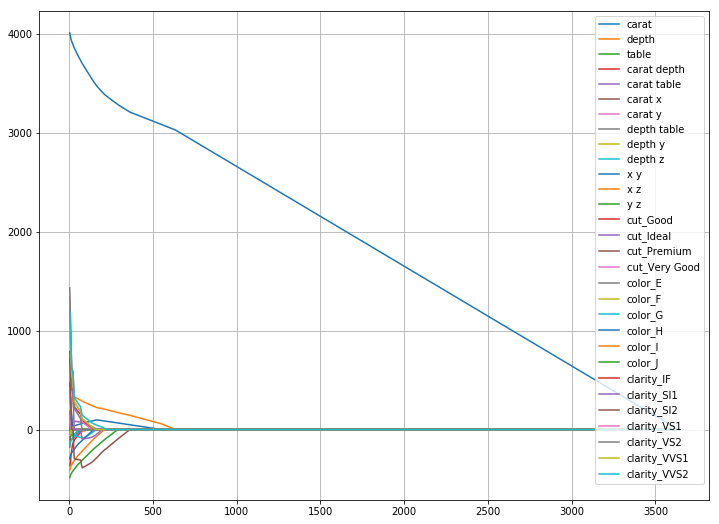

In [224]:
path_lasso = linear_model.lasso_path(X_t, Y_t)
pd.DataFrame(path_lasso[1].T, index=path_lasso[0], columns=X.columns).plot(figsize=[12, 9], grid=True)

In [232]:
model_lasso = linear_model.Lasso(alpha=10)
model_lasso.fit(X_t, Y_t)
Yhat_t = model_lasso.predict(X_t)
Yhat_v = model_lasso.predict(X_v)
print(metrics.mean_squared_error(Y_t, Yhat_t), metrics.mean_squared_error(Y_v, Yhat_v))

1225151.28373 1317950.28495


In [233]:
model_lasso.coef_

array([ 3979.436,   -30.838,   -25.764,  -237.711,  -128.402,    -0.   ,
          -0.   ,     9.816,   254.369,  -168.253,   267.921,   145.786,
          -0.   ,    -0.   ,    94.485,    11.102,    31.61 ,    -0.   ,
         -25.547,  -106.927,  -277.806,  -377.141,  -464.002,   584.63 ,
         739.905,   294.953,   929.289,   963.859,   751.172,   856.191])

In [234]:
model_ridge = linear_model.Ridge(alpha=400)
model_ridge.fit(X_t, Y_t)
Yhat_t = model_ridge.predict(X_t)
Yhat_v = model_ridge.predict(X_v)
print(metrics.mean_squared_error(Y_t, Yhat_t), metrics.mean_squared_error(Y_v, Yhat_v))

1215760.98406 1315151.52614


In [235]:
model_ridge.coef_

array([ 3925.144,   -21.855,   -21.84 ,  -284.757,  -133.916,  -133.955,
          68.884,    11.211,   286.392,  -133.661,   439.727,   155.661,
        -105.376,    80.591,   243.671,   148.562,   161.514,   -51.936,
         -72.097,  -154.215,  -317.344,  -407.241,  -484.052,   581.679,
         744.928,   314.009,   927.283,   960.895,   742.388,   848.527])

In [236]:
print("L1 / L2 beta of Lasso {:.2f} / {:.2f}".format(np.abs(model_lasso.coef_).sum(), (model_lasso.coef_ ** 2).sum()))
print("L1 / L2 beta of Ridge: {:.2f} / {:.2f}".format(np.abs(model_ridge.coef_).sum(), (model_ridge.coef_ ** 2).sum()))
print("L1 / L2 beta of linear reg: {:.2f} / {:.2f}".format(np.abs(model_lm.coef_).sum(), (model_lm.coef_ ** 2).sum()))

L1 / L2 beta of Lasso 11756.92 / 20619685.92
L1 / L2 beta of Ridge: 12963.31 / 20550867.99
L1 / L2 beta of linear reg: 21922.19 / 37426258.89


In [237]:
def cv_train(X, Y, cvfold, f_model=linear_model.LinearRegression, f_loss=metrics.mean_squared_error, **kwargs):
    model_L = []
    for i_cv, ir_v in enumerate(cvfold):
        ir_t = np.concatenate(np.delete(cvfold, i_cv))
        print("CV fold: {} / {}, training / validation sample: {} / {}".format(i_cv, len(cvfold), len(ir_t), len(ir_v)))
        X_t, X_v = X.loc[ir_t], X.loc[ir_v]
        Y_t, Y_v = Y.loc[ir_t], Y.loc[ir_v]
        time_start = time.time()
        model = f_model(**kwargs)
        model.fit(X_t, Y_t)
        Yhat_t = model.predict(X_t)
        Yhat_v = model.predict(X_v)
        loss_t = f_loss(Y_t, Yhat_t)
        loss_v = f_loss(Y_v, Yhat_v)
        print("    Model: {}, training / validation loss of {:.4f} / {:.4f}, time: {:.2f}s".format(
            model.__class__.__name__, loss_t, loss_v, time.time() - time_start))
        model_L.append(model)
    return(model_L)

In [240]:
model_L_lasso = cv_train(X, Y, cvfold, f_model=linear_model.Lasso, alpha=10)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: Lasso, training / validation loss of 1257281.4516 / 1178116.6709, time: 0.17s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: Lasso, training / validation loss of 1232800.9340 / 1301651.6815, time: 0.17s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: Lasso, training / validation loss of 1236627.0369 / 1672570.5187, time: 0.11s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: Lasso, training / validation loss of 1246959.6684 / 1202646.0025, time: 0.15s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: Lasso, training / validation loss of 1225151.2837 / 1317950.2849, time: 0.13s


In [239]:
model_L_ridge = cv_train(X, Y, cvfold, f_model=linear_model.Ridge, alpha=400)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: Ridge, training / validation loss of 1249698.5781 / 1167716.2816, time: 0.02s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: Ridge, training / validation loss of 1224873.3657 / 1292738.6774, time: 0.02s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: Ridge, training / validation loss of 1225851.1420 / 2323788.9323, time: 0.02s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: Ridge, training / validation loss of 1240310.2826 / 1202394.9120, time: 0.02s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: Ridge, training / validation loss of 1215760.9841 / 1315151.5261, time: 0.01s


In [100]:
model_lasso = linear_model.Lasso(alpha=10)
model_lasso.fit(X.loc[ir_lab], Y.loc[ir_lab])
Yhat_test = model_lasso.predict(X_test)
metrics.mean_squared_error(Y_test, Yhat_test)

1373436.6828441089

In [241]:
model_ridge = linear_model.Ridge(alpha=400)
model_ridge.fit(X.loc[ir_lab], Y.loc[ir_lab])
Yhat_test = model_ridge.predict(X_test)
metrics.mean_squared_error(Y_test, Yhat_test)

1307695.1192697012

## Scikit-learn (3.3): Select Penalty Coefficients

- How to select best penalty coeffient $\hat{\lambda}$, or more generally, best hyperparameters of model?
    - Step 1. Try different $\lambda$ on the model
        - Method 1: Build several models with different $\lambda$
        - Method 2: If exists, a stepwise model for $\lambda$ can save computation time
    - Step 2. Calculate CV validation loss, and select the $\hat{\lambda}$ minimizing it
    - Step 3. If used for variable selection, choose important variables under $\hat{\lambda}$

## Scikit-learn(4.1): Decision Tree Models
- Can we detect non-linear relationship without adding polynomial terms?
- Non-linear models: e.g. tree-based methods $\hat{Y} = Tree(X, \theta)$

In [249]:
import sklearn.tree as tree
model_tree = tree.DecisionTreeRegressor()
model_tree.fit(X_t, Y_t)
Yhat_t = model_tree.predict(X_t)
Yhat_v = model_tree.predict(X_v)
print(metrics.mean_squared_error(Y_t, Yhat_t), metrics.mean_squared_error(Y_v, Yhat_v))

26.0344067743 775654.118782


In [253]:
pd.Series(model_tree.feature_importances_, X.columns).sort_values(ascending=False).head(10)

carat           0.644
x y             0.220
clarity_SI2     0.020
carat y         0.014
clarity_SI1     0.014
y z             0.012
color_J         0.012
color_I         0.009
color_H         0.007
clarity_VVS1    0.005
dtype: float64

In [242]:
model_L_tree = cv_train(X, Y, cvfold, tree.DecisionTreeRegressor)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 20.5502 / 724906.2633, time: 0.55s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 23.3130 / 835967.6493, time: 0.53s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 32.0173 / 737821.8172, time: 0.54s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: DecisionTreeRegressor, training / validation loss of 30.0136 / 860066.0633, time: 0.53s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: DecisionTreeRegressor, training / validation loss of 26.0344 / 784917.6993, time: 0.54s


In [244]:
# Limit the depth of tree to control model complexity
model_L_tree = cv_train(X, Y, cvfold, tree.DecisionTreeRegressor, max_depth=15)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 160685.5519 / 663499.0495, time: 0.39s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 162957.4567 / 740674.4441, time: 0.39s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: DecisionTreeRegressor, training / validation loss of 163416.6810 / 694207.7732, time: 0.41s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: DecisionTreeRegressor, training / validation loss of 153775.0330 / 842325.5883, time: 0.40s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: DecisionTreeRegressor, training / validation loss of 166967.6538 / 709757.2085, time: 0.40s


In [255]:
model_tree = tree.DecisionTreeRegressor(max_depth=15)
model_tree.fit(X.loc[ir_lab], Y.loc[ir_lab])
Yhat_test = model_tree.predict(X_test)
metrics.mean_squared_error(Y_test, Yhat_test)

703881.66034046595

In [279]:
def cv_predict(X, Y, model_L, f_loss=metrics.mean_squared_error):
    Yhat_L = []
    for i, model in enumerate(model_L):
        Yhat = model.predict(X)
        loss = f_loss(Y, Yhat)
        print("CV fold: {} / {}, Model: {}, test loss: {:.4f}".format(i, len(model_L), model.__class__.__name__, loss))
        Yhat_L.append(Yhat)
    print("Average CV predictor test loss: {:.4f}".format(f_loss(Y, np.mean(Yhat_L, axis=0))))
    return(np.vstack(Yhat_L).T)

In [280]:
Yhat_cv_tree = cv_predict(X_test, Y_test, model_L_tree)

CV fold: 0 / 5, Model: DecisionTreeRegressor, test loss: 720827.3576
CV fold: 1 / 5, Model: DecisionTreeRegressor, test loss: 821173.3539
CV fold: 2 / 5, Model: DecisionTreeRegressor, test loss: 769580.6414
CV fold: 3 / 5, Model: DecisionTreeRegressor, test loss: 828119.5141
CV fold: 4 / 5, Model: DecisionTreeRegressor, test loss: 753521.4227
Average CV predictor test loss: 529090.8605


## Scikit-learn(4.2): Random Forest

- Build $M$ trees at the same time in each model
- To increase diversity of trees, when building each tree $\hat{\theta}_i$:
    - Randomly bootstrap $(X, Y)$ to $(X_{(i)}, Y_{(i)})$ 
    - Randomly select a subset of variables $\Theta_{i}$
- $\hat{\theta}_i  = \arg\min_{\theta_i \in \Theta_{i}}L\left(Y_{(i)}, Tree(X_{(i)}, \theta_i)\right)$
- $\hat{Y} = \frac{1}{M}\sum_{i=1}^M Tree(X, \hat{\theta}_i)$

In [245]:
from sklearn import ensemble
model_L_rf = cv_train(X, Y, cvfold, ensemble.RandomForestRegressor, n_estimators=10)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: RandomForestRegressor, training / validation loss of 83297.8757 / 454464.0117, time: 3.50s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: RandomForestRegressor, training / validation loss of 83410.5577 / 493339.0047, time: 3.47s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: RandomForestRegressor, training / validation loss of 86083.9441 / 444552.3266, time: 3.48s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: RandomForestRegressor, training / validation loss of 85748.9303 / 494191.9059, time: 3.53s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: RandomForestRegressor, training / validation loss of 92420.4180 / 492346.8307, time: 3.46s


In [246]:
pd.DataFrame([model.feature_importances_ for model in model_L_rf], columns=X.columns).mean().sort_values()

cut_Very Good    2.163e-04
cut_Good         2.278e-04
cut_Premium      3.285e-04
table            7.900e-04
cut_Ideal        7.941e-04
                   ...    
clarity_SI2      1.887e-02
y z              4.553e-02
carat y          8.078e-02
x y              1.198e-01
carat            6.454e-01
Length: 30, dtype: float64

## Scikit-learn(4.3): Gradient Boosting Trees

- Build $M$ trees stepwisely for residuals in each model
- To reduce over-fitting, when building each tree $\hat{\theta}_i$:
    - Restrict max depth of tree
    - Restrict step size $\eta < 1$
- $\hat{\theta}_i  = \arg\min_{\theta_i \in \Theta}L\left(Y - \eta\sum_{j=1}^{i-1}Tree(X, \theta_j), Tree(X, \theta_i)\right)$
- $\hat{Y} = \eta\sum_{i=1}^M Tree(X, \hat{\theta}_i)$

In [247]:
model_L_gbt = cv_train(X, Y, cvfold, ensemble.GradientBoostingRegressor, n_estimators=100, learning_rate=0.2, max_depth=6, max_features=0.3)

CV fold: 0 / 5, training / validation sample: 31766 / 7942
    Model: GradientBoostingRegressor, training / validation loss of 217558.8845 / 404180.2179, time: 4.46s
CV fold: 1 / 5, training / validation sample: 31766 / 7942
    Model: GradientBoostingRegressor, training / validation loss of 218540.9691 / 462562.2644, time: 4.81s
CV fold: 2 / 5, training / validation sample: 31766 / 7942
    Model: GradientBoostingRegressor, training / validation loss of 227652.8995 / 439257.5792, time: 4.52s
CV fold: 3 / 5, training / validation sample: 31767 / 7941
    Model: GradientBoostingRegressor, training / validation loss of 213694.5172 / 449693.4169, time: 4.42s
CV fold: 4 / 5, training / validation sample: 31767 / 7941
    Model: GradientBoostingRegressor, training / validation loss of 215316.0274 / 442238.0211, time: 4.56s


In [248]:
pd.DataFrame([model.feature_importances_ for model in model_L_gbt], columns=X.columns).mean().sort_values()

cut_Good         0.002
cut_Very Good    0.003
cut_Premium      0.005
cut_Ideal        0.007
color_E          0.012
                 ...  
x z              0.058
y z              0.060
carat y          0.077
carat x          0.078
carat            0.168
Length: 30, dtype: float64